***AI Engineer - P9 - Développez une preuve de concept***

# Importation des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from datasets import Dataset

# Fonctions

In [2]:
def inspect_dataframe(df):
    """
    Fonction pour afficher des informations sur un dataframe pandas donné.

    Paramètres:
    df (pd.DataFrame): Le dataframe à inspecter.

    Retourne:
    None
    """
    # Affichage des informations de base
    print(f"Le dataframe comporte {df.shape[0]} observation(s) ou article(s).")
    print(f"Le dataframe comporte {df.shape[1]} colonne(s).")

    # Affichage des types de chaque colonne
    print("\nTypes de chaque colonne:")
    print(df.dtypes)

    # Affichage des valeurs manquantes
    missing = df.isnull().sum()
    percent_missing = df.isnull().mean() * 100
    missing_df = pd.DataFrame({
        'Nombre de valeurs manquantes': missing,
        'Pourcentage': percent_missing
    })
    print("\nNombre et pourcentage de valeurs manquantes par colonne:")
    print(missing_df)

In [3]:
def remove_mentions(df, column_name):
    """
    Supprime tous les mots commençant par un @ dans une colonne spécifique d'un DataFrame.
    
    Parameters:
    df (pd.DataFrame): Le DataFrame contenant les données.
    column_name (str): Le nom de la colonne où les mentions doivent être supprimées.
    
    Returns:
    pd.DataFrame: Le DataFrame avec les mentions supprimées.
    """
    # Fonction pour supprimer les mots commençant par @
    def remove_mentions(text):
        return ' '.join(word for word in text.split() if not word.startswith('@'))
    
    # Appliquer la fonction de nettoyage sur la colonne spécifiée
    df[column_name] = df[column_name].apply(remove_mentions)
    
    return df

In [4]:
# Conversion en Dataset
def encode_data(encodings, labels):
    return Dataset.from_dict({
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels
    })

# Chargement des données

In [5]:
df_tweets = pd.read_csv(r"training.1600000.processed.noemoticon.csv", header=None, encoding='ISO-8859-1')

In [6]:
# Ajout d'un en-tête
df_tweets.columns = ["target", "ids", "date", "flag", "user", "text"]

# Analyse exploratoire des données

In [7]:
inspect_dataframe(df_tweets)

Le dataframe comporte 1600000 observation(s) ou article(s).
Le dataframe comporte 6 colonne(s).

Types de chaque colonne:
target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

Nombre et pourcentage de valeurs manquantes par colonne:
        Nombre de valeurs manquantes  Pourcentage
target                             0          0.0
ids                                0          0.0
date                               0          0.0
flag                               0          0.0
user                               0          0.0
text                               0          0.0


## target

In [8]:
nombre_valeurs_uniques = df_tweets['target'].nunique()
valeurs_uniques = df_tweets['target'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'target': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'target':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'target': 2
Valeurs uniques dans 'target':
[0 4]


**0** correspond à un tweet **négatif**.

**4** correspond à un tweet **positif**.

In [9]:
# Replacement de la valeur 4 (positif) par 1
df_tweets['target'] = df_tweets['target'].apply(lambda x: 1 if x == 4 else 0)

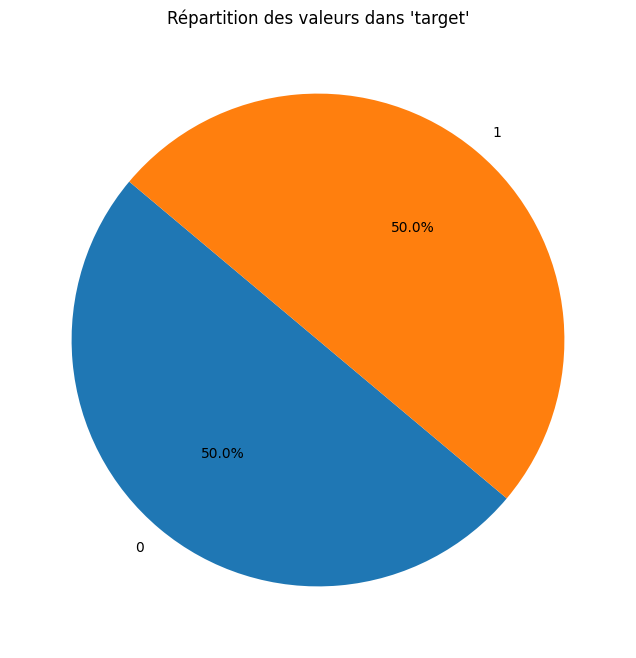

In [10]:
# Compter les occurrences de chaque valeur unique
valeurs_comptes = df_tweets['target'].value_counts()

# Créer le pie plot
plt.figure(figsize=(8, 8))
plt.pie(valeurs_comptes, labels=valeurs_comptes.index, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des valeurs dans 'target'")
plt.show()

On a autant de tweets négatifs que positifs.

## ids

In [11]:
nombre_valeurs_uniques = df_tweets['ids'].nunique()
valeurs_uniques = df_tweets['ids'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'ids': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'ids':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'ids': 1598315
Valeurs uniques dans 'ids':
[1467810369 1467810672 1467810917 ... 2193601991 2193602064 2193602129]


In [12]:
# Doublons dans la colonne 'ids'
doublons = df_tweets[df_tweets.duplicated('ids', keep=False)]

# Tri des doublons par la colonne 'ids' pour regrouper les lignes ayant le même id ensemble
doublons_trie = doublons.sort_values(by='ids')

# Affichage des lignes avec des ids en doublons
print(doublons_trie)

         target         ids                          date      flag  \
213           0  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY   
800261        1  1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY   
800300        1  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY   
275           0  1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY   
989           0  1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599385       1  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY   
1599440       1  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY   
524345        0  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY   
1599931       1  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY   
524688        0  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY   

                 user                                               text  
213          DjGundam  Awwh babs... you look so sad underneith that s...

## date

In [13]:
nombre_valeurs_uniques = df_tweets['date'].nunique()
valeurs_uniques = df_tweets['date'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'date': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'date':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'date': 774363
Valeurs uniques dans 'date':
['Mon Apr 06 22:19:45 PDT 2009' 'Mon Apr 06 22:19:49 PDT 2009'
 'Mon Apr 06 22:19:53 PDT 2009' ... 'Tue Jun 16 08:38:58 PDT 2009'
 'Tue Jun 16 08:39:00 PDT 2009' 'Tue Jun 16 08:40:50 PDT 2009']


## flag

In [14]:
nombre_valeurs_uniques = df_tweets['flag'].nunique()
valeurs_uniques = df_tweets['flag'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'flag': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'flag':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'flag': 1
Valeurs uniques dans 'flag':
['NO_QUERY']


## user

In [15]:
nombre_valeurs_uniques = df_tweets['user'].nunique()
valeurs_uniques = df_tweets['user'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'user': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'user':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'user': 659775
Valeurs uniques dans 'user':
['_TheSpecialOne_' 'scotthamilton' 'mattycus' ... 'EvolveTom'
 'AmandaMarie1028' 'bpbabe']


## text

In [16]:
nombre_valeurs_uniques = df_tweets['text'].nunique()
valeurs_uniques = df_tweets['text'].unique()

# Affichage du nombre de valeurs uniques
print(f"Nombre de valeurs uniques dans 'text': {nombre_valeurs_uniques}")

# Affichage des valeurs uniques
print(f"Valeurs uniques dans 'text':\n{valeurs_uniques}")

Nombre de valeurs uniques dans 'text': 1581466
Valeurs uniques dans 'text':
["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 ... 'Are you ready for your MoJo Makeover? Ask me for details '
 'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur '
 'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H ']


Il y a des tweets en doublons, on va en conserver un seul à chaque fois.

In [17]:
df_tweets = remove_mentions(df_tweets, "text")

In [18]:
df_tweets.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"http://twitpic.com/2y1zl - Awww, that's a bumm..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,I dived many times for the ball. Managed to sa...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"no, it's not behaving at all. i'm mad. why am ..."


In [19]:
# Supprimer les doublons basés sur la colonne 'text'
df_tweets = df_tweets.drop_duplicates(subset='text')

# Optionnel : Réinitialiser l'index après la suppression des doublons
df_tweets.reset_index(drop=True, inplace=True)

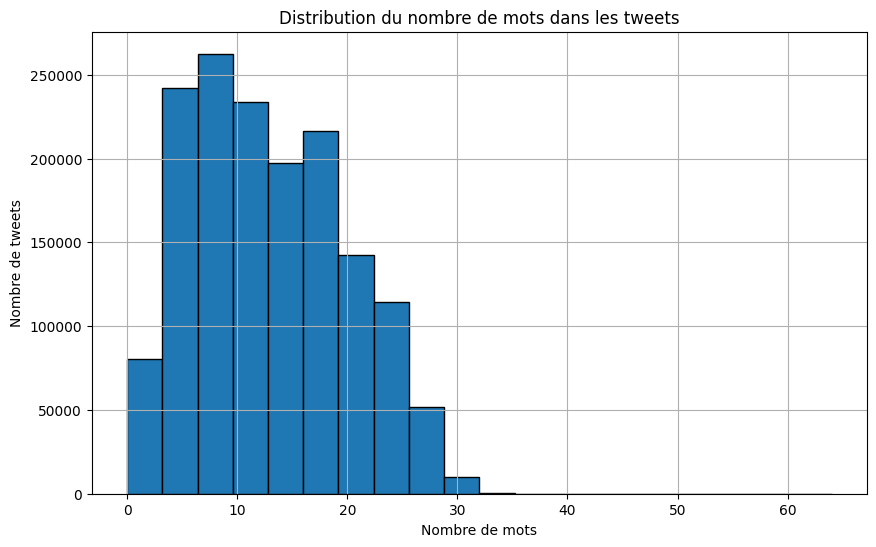

In [20]:
# Calcul du nombre de mots dans chaque tweet
df_tweets['word_count'] = df_tweets['text'].apply(lambda x: len(x.split()))

# Création de l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(df_tweets['word_count'], bins=20, edgecolor='black')
plt.title('Distribution du nombre de mots dans les tweets')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de tweets')
plt.grid(True)
plt.show()

In [21]:
df_tweets['word_count'].describe()

count    1.551387e+06
mean     1.291379e+01
std      6.835337e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.800000e+01
max      6.400000e+01
Name: word_count, dtype: float64

Le tweet le plus petit contient 0 mot, celui le plus long 64 mots. Le nombre moyen de mots par tweet est de 13 mots.

On va supprimer les lignes où le texte ne contient pas de mots.

In [22]:
# Filtrage des lignes où le nombre de mots est supérieur à 0
df_tweets = df_tweets[df_tweets['word_count'] > 0].reset_index(drop=True)

# Affichage du dataFrame filtré
df_tweets.head()

,target,ids,date,flag,user,text,word_count
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"http://twitpic.com/2y1zl - Awww, that's a bumm...",18
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,21
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,I dived many times for the ball. Managed to sa...,17
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,10
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"no, it's not behaving at all. i'm mad. why am ...",20


In [23]:
df_tweets['word_count'].describe()

count    1.551386e+06
mean     1.291379e+01
std      6.835332e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.200000e+01
75%      1.800000e+01
max      6.400000e+01
Name: word_count, dtype: float64

In [24]:
df_tweets.shape

(1551386, 7)

# Création du dataframe final

In [25]:
df = df_tweets[['target', 'text']]

In [26]:
# Sélection de 25 000 tweets négatifs
df_negatifs = df[df['target'] == 0].sample(n=25000, random_state=42)

# Sélection de 25 000 tweets positifs
df_positifs = df[df['target'] == 1].sample(n=25000, random_state=42)

# Regroupement des deux DataFrames
df_final = pd.concat([df_negatifs, df_positifs], ignore_index=True)

In [27]:
df_final.shape

(50000, 2)

In [28]:
df_final.head()

,target,text
0,0,"Borderline suicidal, started at half 10 today ..."
1,0,i was in your store on monday didnt see you i ...
2,0,"where have you been,you better come with me to..."
3,0,Had to cut my round short
4,0,"Mannn I neva get to see you anymore aunte,"


In [44]:
filename = "datas/df_final.csv"
df_final.to_csv(filename, index=False)

In [29]:
# Séparer les données
X = df_final['text']
y = df_final['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chargement des modèles existants

In [30]:
with open("Tf-idf_MLP-Classifier_model.pkl", "rb") as f:
    mlp_model = pickle.load(f)

In [31]:
with open("tfidf_model.pkl", "rb") as f:
    tfidf_vectorizer = pickle.load(f)

# Prédictions avec le modèle MLP Classifier

In [32]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
mlp_predictions = mlp_model.predict(X_test_tfidf)

In [33]:
# Calcul des métriques pour la baseline
print("\n=== MLP Classifier ===")
print(f"Accuracy: {accuracy_score(y_test, mlp_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, mlp_predictions, average='weighted'):.4f}")
print(f"AUC: {roc_auc_score(y_test, mlp_predictions):.4f}")
print(classification_report(y_test, mlp_predictions))


=== MLP Classifier ===
Accuracy: 0.6841
F1 Score: 0.6608
AUC: 0.6853
              precision    recall  f1-score   support

           0       0.89      0.42      0.57      5022
           1       0.62      0.95      0.75      4978

    accuracy                           0.68     10000
   macro avg       0.76      0.69      0.66     10000
weighted avg       0.76      0.68      0.66     10000



# Prédictions avec DistilBERT

In [34]:
# Initialisation de DistilBERT
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Préparation des données pour DistilBERT
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

In [36]:
train_dataset = encode_data(train_encodings, list(y_train))
test_dataset = encode_data(test_encodings, list(y_test))

In [38]:
# Entraîner le modèle DistilBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # Augmenté à 32
    num_train_epochs=5,  # Jusqu’à 5 pour plus de robustesse
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs"
)

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.402900,0.384421
2,0.316100,0.396414
3,0.220500,0.474383
4,0.155900,0.558928
5,0.117000,0.639850


TrainOutput(global_step=6250, training_loss=0.24610052276611327, metrics={'train_runtime': 32922.4925, 'train_samples_per_second': 6.075, 'train_steps_per_second': 0.19, 'total_flos': 6623369932800000.0, 'train_loss': 0.24610052276611327, 'epoch': 5.0})

In [40]:
# Sauvegarder le modèle fine-tuné et le tokenizer
output_dir = "./distilbert_finetuned_v2"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Modèle et tokenizer sauvegardés dans le répertoire : {output_dir}")

Modèle et tokenizer sauvegardés dans le répertoire : ./distilbert_finetuned_v2


In [41]:
# Évaluer le modèle DistilBERT
predictions = trainer.predict(test_dataset)
pred_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

In [42]:
# Calcul des métriques pour DistilBERT
print("\n=== DistilBERT ===")
print(f"Accuracy: {accuracy_score(y_test, pred_labels):.4f}")
print(f"F1 Score: {f1_score(y_test, pred_labels, average='weighted'):.4f}")
print(f"AUC: {roc_auc_score(y_test, pred_labels):.4f}")
print(classification_report(y_test, pred_labels))


=== DistilBERT ===
Accuracy: 0.8229
F1 Score: 0.8229
AUC: 0.8229
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      5022
           1       0.82      0.83      0.82      4978

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

